# Benchmarking antimicrobial peptides


In this notebook, we use seqme to evaluate antimicrobial peptide sequences.


In [ ]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch

import seqme as sm

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Data


Let's load the datasets.


In [ ]:
BASE_PATH = Path("./docs/tutorials")

DATASET_PATHS = {
    # Databases
    "UniProt": BASE_PATH / "data/dbs/uniprot/uniprot_8_50_100.fasta",
    "AMP-data": BASE_PATH / "data/dbs/amps.fasta",
    "AMPs": BASE_PATH / "data/dbs/amps_hq.fasta",
    "DBAASP": BASE_PATH / "data/dbs/dbaasp.fasta",
    # Models
    # "AMP-Cao": BASE_PATH / "data/models/amp_cao.fasta", # has "X"
    "AMP-translstm": BASE_PATH / "data/models/amp_translstm.fasta",
    "AMP-Diffusion": BASE_PATH / "data/models/amp-diffusion.fasta",
    "AMP-GAN": BASE_PATH / "data/models/amp-gan.fasta",
    "AMP-GAN2": BASE_PATH / "data/models/ampgan10k.fasta",
    "CPL-Diff": BASE_PATH / "data/models/cpl-diff.fasta",
    "HydrAMP": BASE_PATH / "data/models/hydramp.fasta",
    "Hyformer": BASE_PATH / "data/models/hyf_seq.fasta",
    # "mlpeptide": BASE_PATH / "data/models/mlpeptide10k.fasta", # some are lower case
    "MMCD": BASE_PATH / "data/models/MMCD.fasta",
    "CVAE": BASE_PATH / "data/models/unconstrained_cvae_basic_sequences.fasta",
    "PepCVAE": BASE_PATH / "data/models/unconstrained_pepcvae_sequences.fasta",
    # "Zeng et. al.": BASE_PATH / "data/models/zeng.fasta", # has "X"
    "OmegAMP": BASE_PATH / "data/models/omegamp/unconditional.fasta",
    "OmegAMP (prop.)": BASE_PATH / "data/models/omegamp/property-conditional.fasta",
    "OmegAMP (subset)": BASE_PATH / "data/models/omegamp/subset-hq-conditional.fasta",
    #
}

In [ ]:
datasets = {name: sm.read_fasta(path) for name, path in DATASET_PATHS.items()}

In [ ]:
for model_name, sequences in datasets.items():
    print(f"{model_name}: {len(sequences)} sequences")

UniProt: 2933310 sequences
AMP-data: 38473 sequences
AMPs: 7204 sequences
DBAASP: 8967 sequences
AMP-translstm: 36003 sequences
AMP-Diffusion: 47671 sequences
AMP-GAN: 150000 sequences
AMP-GAN2: 5008 sequences
CPL-Diff: 49985 sequences
HydrAMP: 50000 sequences
Hyformer: 50000 sequences
MMCD: 18890 sequences
CVAE: 50000 sequences
PepCVAE: 50000 sequences
OmegAMP: 149504 sequences
OmegAMP (prop.): 50000 sequences
OmegAMP (subset): 49152 sequences


In [ ]:
AMINO_ACID_LETTERS = list("ACDEFGHIKLMNPQRSTVWY")
AMINO_ACID_SET = set(AMINO_ACID_LETTERS)


def verify(sequence: str):
    invalid = set(sequence) - AMINO_ACID_SET
    if invalid:
        raise ValueError(f"Invalid amino acid(s): {', '.join(sorted(invalid))}")


for model_name, sequences in datasets.items():
    print(f"Parsing '{model_name}'")
    for sequence in sequences:
        verify(sequence)

Parsing UniProt


Parsing AMP-data
Parsing AMPs
Parsing DBAASP
Parsing AMP-translstm
Parsing AMP-Diffusion
Parsing AMP-GAN
Parsing AMP-GAN2
Parsing CPL-Diff
Parsing HydrAMP
Parsing Hyformer
Parsing MMCD
Parsing CVAE
Parsing PepCVAE
Parsing OmegAMP
Parsing OmegAMP (prop.)
Parsing OmegAMP (subset)


Let's setup the data and models.


In [ ]:
sources = list(DATASET_PATHS.keys())

n_samples = 3_000  # 40_000  # 3_000
seed = 42

benchmark_datasets = {
    source: sm.utils.subsample(datasets[source], n_samples=n_samples, seed=seed)
    if len(datasets[source]) > n_samples
    else datasets[source]
    for source in sources
}
# benchmark_datasets["DBAASP (shuffled)"] = sm.utils.shuffle_characters(datasets["DBAASP"], seed=seed)
benchmark_datasets["AMP-data (permuted)"] = sm.utils.shuffle_characters(benchmark_datasets["AMP-data"], seed=42)

seqs_uniprot = datasets["UniProt"]
seqs_amps = datasets["AMPs"]
seqs_train = datasets["AMP-data"]

## Models


Let's load the models and set up the cache.


In [ ]:
CACHE_PATH = "new_cache.pkl"

init_cache = sm.read_pickle(CACHE_PATH) if CACHE_PATH else None

Let's setup the third-party models.


Let's setup AMPlify.


In [ ]:
# !conda create -n amplify_env python=3.9 -y

In [ ]:
amplify = sm.models.ThirdPartyModel(
    entry_point="predict:predict",
    repo_path="../plugins/thirdparty/amplify",
    # python_bin="/opt/anaconda3/envs/amplify_env/bin/python",
    python_bin="/home/icb/rasmus.larsen/tools/apps/miniconda3/envs/amplify_env/bin/python",
    repo_url="https://github.com/szczurek-lab/seqme-thirdparty",
    branch="amplify",
)

Let's setup amPEPpy.


In [ ]:
# !conda create -n ampeppy_env python=3.8 -y

In [ ]:
ampeppy = sm.models.ThirdPartyModel(
    entry_point="amPEPpy.predict:predict",
    repo_path="../plugins/thirdparty/ampep",
    # python_bin="/opt/anaconda3/envs/ampep_env/bin/python",
    python_bin="/home/icb/rasmus.larsen/tools/apps/miniconda3/envs/ampeppy_env/bin/python",
    repo_url="https://github.com/szczurek-lab/seqme-thirdparty",
    branch="ampeppy",
)

Let's setup the cache.


In [ ]:
def my_embedder(sequences: list[str]) -> np.ndarray:
    lengths = [len(sequence) for sequence in sequences]
    counts = [sequence.count("K") for sequence in sequences]
    return np.array([lengths, counts]).T


esm2 = sm.models.ESM2(
    model_name=sm.models.ESM2Checkpoint.t6_8M,
    batch_size=512,
    device=device,
    verbose=False,
)

cache = sm.Cache(
    models={
        "embedder": my_embedder,
        "esm2-embed": esm2.embed,
        "esm2-perplexity": lambda seqs: esm2.compute_pseudo_perplexity(seqs, mask_size=3),
        "gravy": sm.models.Gravy(),
        "charge": sm.models.Charge(),
        "amphiphilicity": sm.models.HydrophobicMoment(),
        "amPEPpy": ampeppy,
        "AMPlify": amplify,
    },
    init_cache=init_cache,
)

## Plotting

Let's look at the embeddings of the embedding model.


In [ ]:
datasets_to_plot_names = ["UniProt", "AMP-data"]
# @TODO: include shuffled AMP-data?

colors = ["#d66868", "#68d6bc"]

n_samples = 30_000
seed = 42

datasets_to_plot = {
    name: sm.utils.subsample(datasets[name], n_samples=n_samples, seed=seed)
    if len(sequences) > n_samples
    else datasets[name]
    for name in datasets_to_plot_names
}

In [ ]:
embedder_name = "esm2-embed"
embedder = cache.model(embedder_name)

embeddings = {name: embedder(dataset) for name, dataset in datasets_to_plot.items()}

In [ ]:
uniprot = sm.utils.subsample(datasets["UniProt"], n_samples=30_000, seed=42)

In [ ]:
charge_fn = cache.model("charge")
amphiphilicity_fn = cache.model("amphiphilicity")

uniprot_charge = charge_fn(uniprot)
uniprot_amphiphilicity = amphiphilicity_fn(uniprot)

amp_data_charge = charge_fn(seqs_amps)
amp_data_amphiphilicity = amphiphilicity_fn(seqs_amps)

In [ ]:
xs_tsne = sm.utils.tsne(list(embeddings.values()))

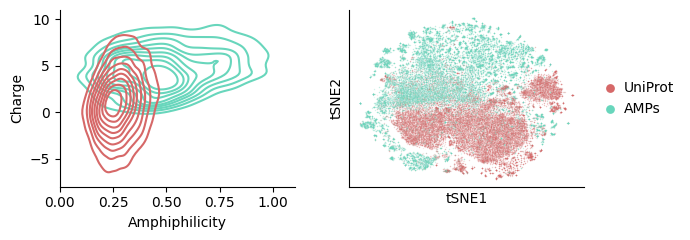

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(7, 2.5))  # , dpi=200)

ax = axes[0]

sns.kdeplot(
    x=amp_data_amphiphilicity,
    y=amp_data_charge,
    fill=False,
    thresh=0.15,
    color="#68d6bc",
    ax=ax,
    bw_method="silverman",
)

sns.kdeplot(
    x=uniprot_amphiphilicity,
    y=uniprot_charge,
    fill=False,
    thresh=0.15,
    color="#d66868",
    ax=ax,
    bw_method="silverman",
)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_xlim([0, 1.1])
ax.set_ylim([-8, 11])
ax.set_xlabel("Amphiphilicity")
ax.set_ylabel("Charge")

ax = axes[1]

sm.utils.plot_embeddings(
    xs_tsne,
    colors=colors,
    alpha=0.15,
    point_size=1,
    legend_point_size=40,
    ax=ax,
    xlabel="tSNE1",
    ylabel="tSNE2",
    values=["UniProt", "AMPs"],
)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

leg = ax.legend(
    loc="center left",
    bbox_to_anchor=(1.0, 0.5),
    frameon=False,
    handletextpad=0,
    # fontsize=9,
)

for lh in leg.legend_handles:
    lh.set_sizes([40])
    lh.set_alpha(1.0)

fig.tight_layout(w_pad=2.5)

Using "Silverman" to estimate the kde bandwidth appears to work well here. Also notice AMPs usually have a positive charge.


## Metrics


Let's select the metrics.


In [ ]:
embedder = "esm2-embed"  # "embedder"


metrics = [
    sm.metrics.Count(),
    sm.metrics.Uniqueness(),
    sm.metrics.Diversity(k=5, name="Diversity (5)"),
    sm.metrics.Novelty(reference=seqs_train),
    sm.metrics.FKEA(embedder=cache.model(embedder), bandwidth=1.0, strict=False),
    sm.metrics.FBD(reference=seqs_uniprot, embedder=cache.model(embedder), name="FBD (UniProt)"),
    # sm.metrics.MMD(reference=seqs_uniprot, embedder=cache.model(embedder), name="MMD (UniProt)"),
    sm.metrics.FBD(reference=seqs_amps, embedder=cache.model(embedder)),
    # sm.metrics.MMD(reference=seqs_amps, embedder=cache.model(embedder)),
    # sm.metrics.Fold(
    #    sm.metrics.Precision(
    #        n_neighbors=3, reference=seqs_train, embedder=cache.model(embedder), strict=True, device=device
    #    ),
    #    split_size=len(seqs_train),
    #    drop_last=True,
    # ),
    # sm.metrics.Fold(
    #    sm.metrics.Recall(
    #        n_neighbors=3, reference=seqs_train, embedder=cache.model(embedder), strict=True, device=device
    #    ),
    #    split_size=len(seqs_train),
    #    drop_last=True,
    # ),
    # ID(predictor=cache.model("hyformer-perplexity"), name="Perplexity", objective="minimize"),
    # sm.metrics.ID(predictor=cache.model("AMPlify"), name="AMPlify", objective="maximize"),
    sm.metrics.ID(predictor=cache.model("amPEPpy"), name="amPEPpy", objective="maximize"),
    sm.metrics.AuthPct(train_set=seqs_train, embedder=cache.model(embedder)),
    sm.metrics.ConformityScore(
        reference=seqs_amps,
        predictors=[cache.model("amphiphilicity"), cache.model("charge")],
        kde_bandwidth="silverman",
    ),
]

`Fold` computes the metrics multiple using different folds, and aggregate the values (mean and standard deviation).

Wrapping `Fold` around the `Precision` and `Recall` metric, removes the sample size bias inherent in these metrics (introduced by k-NN), while still utilizing as many of the available sequences as possible.


## Table


Let's compute the metrics for each group of sequences.


In [ ]:
df = sm.evaluate(benchmark_datasets, metrics)

100%|██████████| 180/180 [08:34<00:00,  2.86s/it, data=AMP-data (permuted), metric=Conformity score]


In [ ]:
OUT_CACHE_PATH = "new_cache.pkl"

sm.to_pickle(cache.get(), OUT_CACHE_PATH)

Let's look at the results.


In [ ]:
sm.show(df, color_style="bar")

,Count↑,Uniqueness↑,Diversity (5)↑,Novelty↑,FKEA↑,FBD (UniProt)↓,FBD↓,amPEPpy↑,Authenticity↑,Conformity score↑
UniProt,3000.00,1.00,0.84,1.00,266.13,0.06,5.50,0.60±0.14,0.83,0.25±0.00
AMP-data,3000.00,1.00,0.86,0.00,339.65,2.97,1.33,0.62±0.21,0.00,0.37±0.00
AMPs,3000.00,1.00,0.82,0.00,359.85,5.53,0.02,0.76±0.15,0.00,0.51±0.00
DBAASP,3000.00,0.99,0.85,0.10,360.99,3.45,0.74,0.67±0.21,0.09,0.41±0.00
AMP-translstm,3000.00,1.00,0.82,1.00,30.65,2.25,8.88,0.53±0.38,0.96,0.09±0.00
AMP-Diffusion,3000.00,0.97,0.82,1.00,344.12,2.80,2.30,0.35±0.22,0.89,0.35±0.00
AMP-GAN,3000.00,1.00,0.81,1.00,123.37,2.74,5.04,0.48±0.22,0.82,0.44±0.00
AMP-GAN2,3000.00,1.00,0.79,1.00,169.74,3.69,3.88,0.63±0.15,0.84,0.52±0.00
CPL-Diff,3000.00,0.99,0.83,0.99,398.80,6.47,0.71,0.70±0.16,0.87,0.42±0.00
HydrAMP,3000.00,1.00,0.86,1.00,380.39,6.51,4.72,0.52±0.15,0.91,0.32±0.00


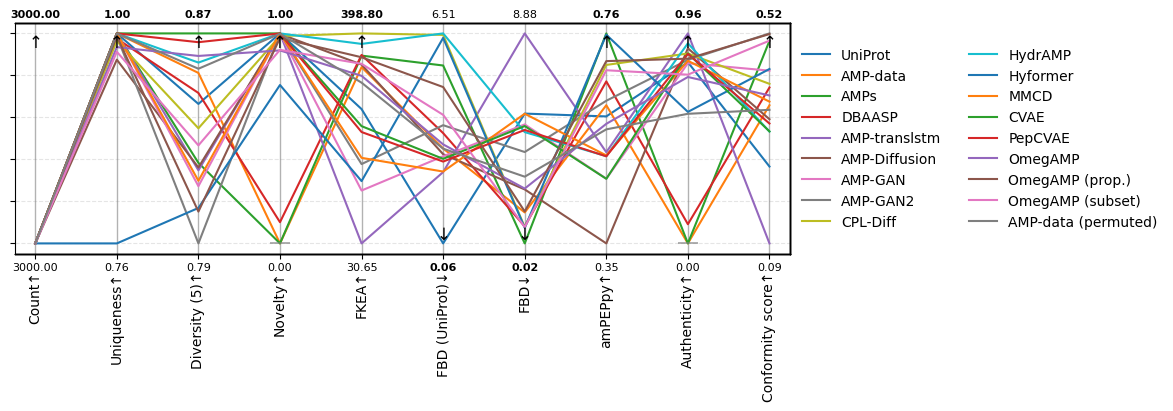

In [ ]:
sm.plot_parallel(df, arrow_size=12, figsize=(10, 3))

Post analysis.

In [ ]:
properties = {name: cache.model("charge")(sequences) for name, sequences in benchmark_datasets.items()}

/localscratch/ipykernel_2515221/1180707910.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(properties.keys(), rotation=90, ha="center")


<Axes: ylabel='Charge'>

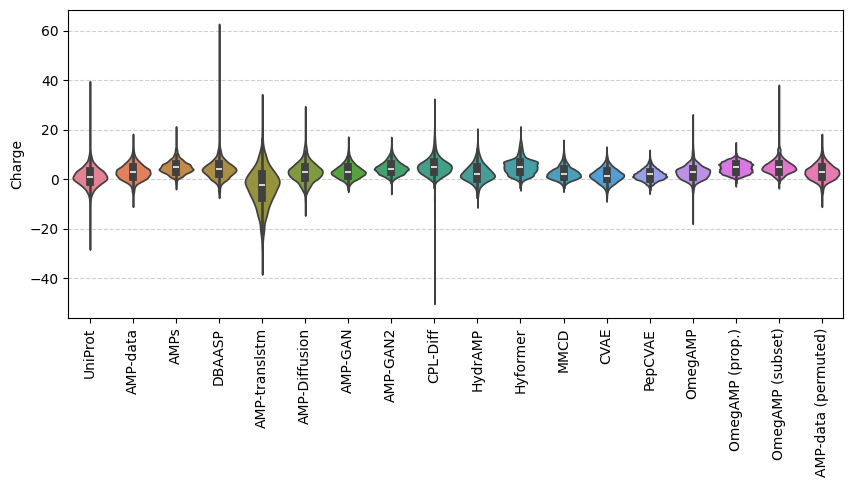

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.grid(axis="y", linestyle="--", alpha=0.6)
ax.set_axisbelow(True)
ax.set_ylabel("Charge")
ax.set_xticklabels(properties.keys(), rotation=90, ha="center")
sns.violinplot(properties, bw_method="scott", ax=ax)

In [ ]:
sources = ["UniProt", "AMP-data", "AMPs", "DBAASP", "AMP-translstm", "CPL-Diff", "Hyformer", "OmegAMP"]

embeddings = {source: cache.model(embedder)(benchmark_datasets[source]) for source in sources}

embedding_names = list(embeddings.keys())
embedding_values = list(embeddings.values())

In [ ]:
proj = sm.utils.tsne(embedding_values)
proj = dict(zip(embedding_names, proj, strict=True))

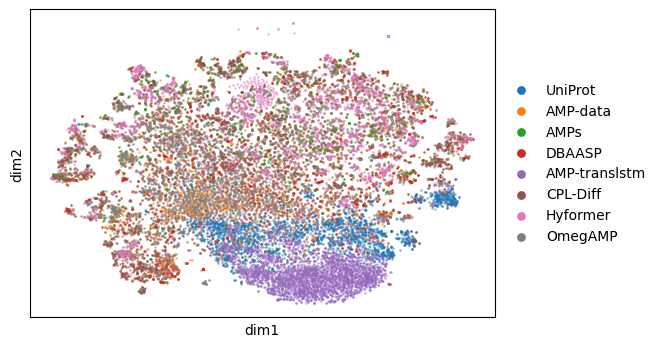

In [ ]:
sm.utils.plot_embeddings(
    proj.values(),
    values=proj.keys(),
    xlabel="dim1",
    ylabel="dim2",
    point_size=3,
    legend_point_size=40,
    figsize=(6, 4),
)